# Сентимент анализ сообщений Twitter

In [1]:
import pandas as pd
import numpy as np
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk import FreqDist, classify, NaiveBayesClassifier
from sklearn.feature_extraction.text import CountVectorizer
import re, string, random

In [2]:
file = 'eng_data.xlsx'
data = pd.ExcelFile(file).parse()

In [3]:
data.head()

,tweet,sentiment
0,#stl we war ready #ripmikebrown #ferguson http...,2
1,one of the best moments from ystrdy was when a...,2
2,public art. canfield. photo. #ferguson http://...,3
3,canfield. public art cont. #ferguson http://if...,3
4,public art exhibit. canfield. #ferguson http:/...,3


In [4]:
data.shape

(1205, 2)

In [5]:
data.describe()

,sentiment
count,1205.000000
mean,2.378423
std,0.742313
min,1.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,3.000000


In [6]:
tweets = list(data['tweet'])

In [7]:
y = list(data['sentiment'])

In [8]:
# def lemmatize_sentence(tweets):
#     tokens = word_tokenize(tweets)
#     lemmatizer = WordNetLemmatizer()
#     lemmatized_sentence = []
#     for word, tag in pos_tag(tokens):
#         if tag.startswith('NN'):
#             pos = 'n'
#         elif tag.startswith('VB'):
#             pos = 'v'
#         else:
#             pos = 'a'
#         lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
#     return lemmatized_sentence

def remove_noise(tweet_tokens, stop_words = ()):
    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)

        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words\
                                                                and token.count('pic.twitter') == 0:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

def clean_review(review):
    """
    Receives a raw review and clean it using the following steps:
    1. Remove all non-words
    2. Transform the review in lower case
    3. Remove all stop words
    4. Perform stemming

    Args:
        review: the review that iwill be cleaned
    Returns:
        a clean review using the mentioned steps above.
    """
    
    review = re.sub("[^A-Za-z]", " ", review)
    review = review.lower()
    review = word_tokenize(review)
    stemmer = PorterStemmer()
    review = [stemmer.stem(word) for word in review if word not in set(stopwords.words("english"))]
    review = " ".join(review)
    return review

In [9]:
stop_words = stopwords.words('english')

In [10]:
from nltk.tokenize import casual_tokenize
tokens_tweets = []
for tweet in tweets:
        tokens_tweets.append(casual_tokenize(tweet))

In [11]:
clean_token_tweets = []
for token in tokens_tweets:
        clean_token_tweets.append(remove_noise(token, stop_words))

In [12]:
def joinmy(review):
    review = " ".join(review)
    return review
clean_token_tweets_predl = [joinmy(i) for i in clean_token_tweets ]

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
values = tfidf_vectorizer.fit_transform(clean_token_tweets_predl)

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(values, y, test_size = 0.3, random_state = 11)

In [41]:
X_test.shape

(362, 2934)

## Обучение классическими метоами

In [16]:
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

In [17]:
rfc = ensemble.RandomForestClassifier(n_jobs=-1)
param_grid = {
    'n_estimators': [100,200,300],
    'max_features': ['auto', 'sqrt', 'log2']
}
CV_rfc = GridSearchCV(rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(X_train, y_train)

print (CV_rfc.best_params_)

{'max_features': 'log2', 'n_estimators': 200}


In [18]:
rf = ensemble.RandomForestClassifier(n_jobs=-1,max_features='log2',n_estimators=200)
rf.fit(X_train, y_train)
err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))
print (err_train, err_test)

0.0035587188612099642 0.35911602209944754


## Тест модуль

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix as conf_matr
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

def score_test(y_true,y_pred):#на вход истинные метки и предсказанные
    
    cm = conf_matr(y_true,y_pred) #обычная
    cmn = conf_matr(y_true,y_pred,normalize ='true') #нормированная
    class_names = ['positive','negative','neutral']

    #строим графики
    for matr in [cm,cmn]:
        disp = ConfusionMatrixDisplay(confusion_matrix=matr,display_labels=class_names)
        disp = disp.plot(cmap=plt.cm.Blues)

    plt.show()
    print(cm,'\n','\n',cmn,'\n')
    accuracy = float((1 - np.mean(y_true  != y_pred)))
    f1 = f1_score(y_true,y_pred,average = 'weighted')
    print(f'accuracy = {accuracy}')
    print(f'F1 score = {f1}')

In [3]:
# from test import score_test

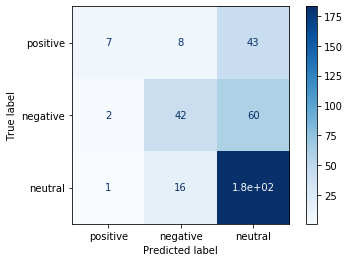

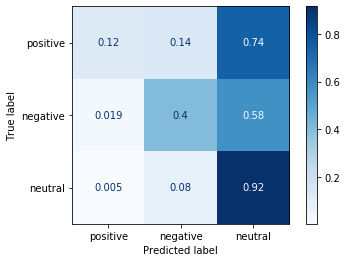

[[  7   8  43]
 [  2  42  60]
 [  1  16 183]] 
 
 [[0.12068966 0.13793103 0.74137931]
 [0.01923077 0.40384615 0.57692308]
 [0.005      0.08       0.915     ]] 

accuracy = 0.6408839779005524
F1 score = 0.5910129715892906


In [35]:
score_test(y_test,rf.predict(X_test))

## Обучение нейронками